In [4]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv('../data/external/stats/pokemon.csv')
pokemon["Variety"] = float("NaN")
pokemon = pokemon[["#", "Name", "Variety", "Type 1", "Type 2"]]

# Create one-hot columns for each type
types = set(pokemon["Type 1"])
for t in types:
    pokemon["is" + str(t)] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    # Clean up name
    pokemonName = pokemon.loc[i, "Name"]
    pokemonName = pokemonName.replace(" ", "")
    
    pokemonNameComponents = re.findall('[A-Z][^A-Z0-9]*', pokemonName)

    pokemon.loc[i, "Name"] = pokemonNameComponents[0]
    
    # Set variety (Mega etc.)
    if len(pokemonNameComponents) > 1:
        pokemonNameComponents = [value for value in pokemonNameComponents if value != pokemonNameComponents[0]]
        pokemon.loc[i, "Variety"] = str(pokemonNameComponents).lower()
    else:
        pokemon.loc[i, "Variety"] = "normal"
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["Type 1"]] = 1

    if not pd.isna(p["Type 2"]):
        pokemon.loc[i, "is" + p["Type 2"]] = 1

# Ditch all Pokemon with varieties (e.g. Megas):
pokemon = pokemon[pokemon["Variety"] == "normal"]


# Save output
pokemon.to_csv('../data/processed/pokemon.csv', index=False)

pokemon.head()

In [ ]:
# Process image data

data_directory_images = "../data/external/images-gen-1-6"
output_directory = "../data/processed/pokemon"

pokemon = pd.read_csv('../data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images + "/" + image
        dst = output_directory + "/" + pokemon_id + ".png"

        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["#"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv('../data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

In [ ]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon.iloc[i]["imagePath"])
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

X.shape

In [5]:
# Create labels

y = np.array(pokemon.drop(['#', 'Name', 'Variety', 'Type 1', 'Type 2', 'imagePath'], axis=1))

y.shape

(693, 18)

In [6]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(623, 256, 256, 3) (623, 18)
(70, 256, 256, 3) (70, 18)


In [2]:
# Create model

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(256,256,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.10))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.10))
model.add(Dense(18, activation='sigmoid'))

model.summary()

model.compile(
    optimizer='adam'
    , loss='CategoricalCrossentropy'
    , metrics=['accuracy']
)

NameError: name 'Sequential' is not defined

In [3]:
# Train model

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128)

NameError: name 'model' is not defined

1/1 [==============================] - 0s 15ms/step
isGround (1.0)
isPoison (1.0)
isGhost (1.0)


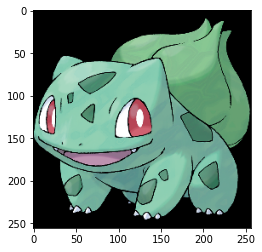

In [20]:
img = tf.keras.utils.load_img('../data/processed/pokemon/1.png',target_size=(256,256,3))
img = tf.keras.utils.img_to_array(img)
img = img/255


classes = np.array(pokemon.columns[5:-1])
proba = model.predict(img.reshape(1,256,256,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)